Exercises:
- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.


- E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.




# E01 
- Find out the issue with setting everything to be 0 initially.

I'm gonna use the pytorchified version just because then we can figur 

In [117]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [118]:
# read in all the words
words = open('../2 - makemore/names.txt', 'r').read().splitlines()
words[:8]
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
len(words)


32033

In [119]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [120]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [121]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *0 # * (5/3)/((n_embd*block_size)**0.5) # 0.2# tanh part; make hpreact closer to 0
b1 = torch.randn(n_hidden,                        generator=g) *0 # * 0.01 # tanh bit
W2 = torch.randn((n_hidden, vocab_size),          generator=g) *0 #* 0.01 # initial loss
b2 = torch.randn(vocab_size,                      generator=g) * 0 # for initial loss

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [122]:
# same optimisation as last time
# same optimization as last time
max_steps = 30000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer ## LOOK, IF EVERYTHING IS INITIALISED TO 0, ONLY B2 CAN LEARN! h "Blocks" everything
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  30000: 3.2958
  10000/  30000: 2.6793
  20000/  30000: 2.8210


In [123]:
def inspect(n: torch.Tensor):
	print(n.shape)
	print(n.grad)
	# print(n.data)


torch.Size([200])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([30, 200])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
       

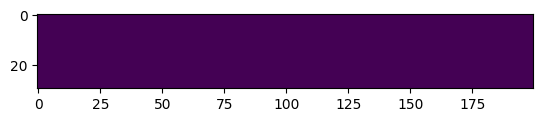

In [124]:
plt.imshow(W1.grad)
# Okay, so W1 and b1 aren't learning/training
inspect(b1)
inspect(W1)

In [125]:
inspect(W2)
inspect(b2)

# And neither is W2. The only thing that is learning over time is b2, 

torch.Size([200, 27])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([27])
tensor([-0.0461,  0.0568,  0.0117, -0.0160, -0.0069,  0.0287,  0.0039,  0.0077,
         0.0321,  0.0444,  0.0128,  0.0234, -0.0328, -0.0020,  0.0153, -0.0291,
         0.0042,  0.0011, -0.1927,  0.0361, -0.0079,  0.0144,  0.0108,  0.0039,
         0.0029,  0.0438, -0.0207])


In [126]:
# print((h == 0).sum() == h.shape[0] * h.shape[1]) # Just a weird way of me saying that everything in h is 0 lol. First 
h # Everything is 0 in here
hpreact # Everything 0 in here too!

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<AddBackward0>)

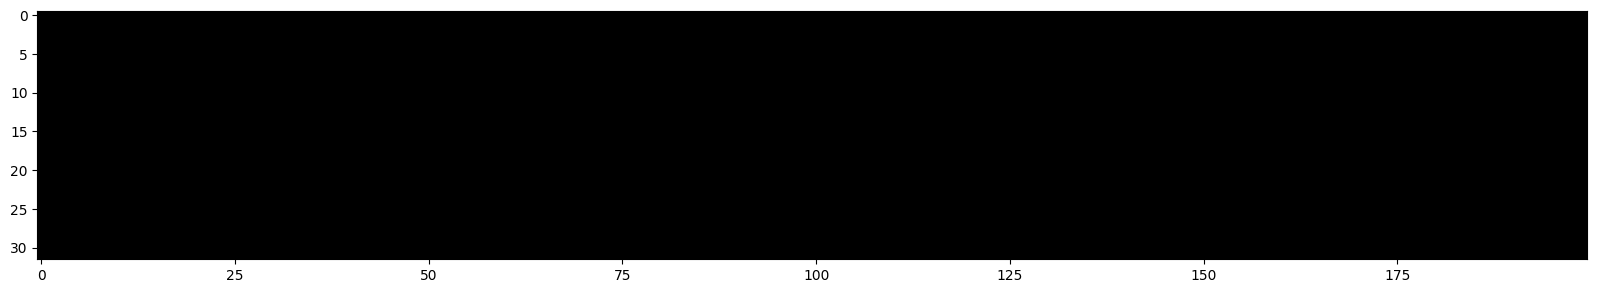

In [127]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

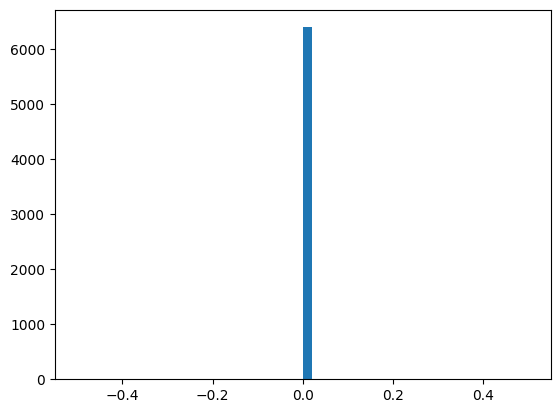

In [128]:
plt.hist(h.view(-1).tolist(),50);

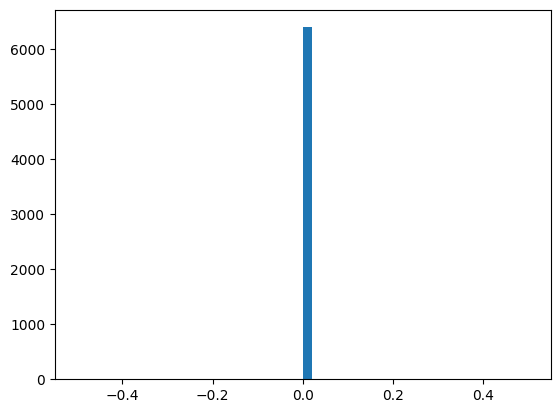

In [129]:
plt.hist(hpreact.view(-1).tolist(),50);

In [131]:
print(logits.shape, b2.shape)

print(logits, b2)

torch.Size([32, 27]) torch.Size([27])
tensor([[ 1.9502,  2.0129, -0.5405, -0.2786,  0.1923,  1.5109, -1.6320, -0.9601,
          0.4680,  1.3248, -0.4503,  0.1516,  1.1088,  0.3753,  1.3524,  0.5058,
         -1.5598, -2.9263,  1.0459,  0.5856,  0.1470, -0.3376, -0.6212, -1.6399,
         -1.9213,  0.7778, -0.6418],
        [ 1.9502,  2.0129, -0.5405, -0.2786,  0.1923,  1.5109, -1.6320, -0.9601,
          0.4680,  1.3248, -0.4503,  0.1516,  1.1088,  0.3753,  1.3524,  0.5058,
         -1.5598, -2.9263,  1.0459,  0.5856,  0.1470, -0.3376, -0.6212, -1.6399,
         -1.9213,  0.7778, -0.6418],
        [ 1.9502,  2.0129, -0.5405, -0.2786,  0.1923,  1.5109, -1.6320, -0.9601,
          0.4680,  1.3248, -0.4503,  0.1516,  1.1088,  0.3753,  1.3524,  0.5058,
         -1.5598, -2.9263,  1.0459,  0.5856,  0.1470, -0.3376, -0.6212, -1.6399,
         -1.9213,  0.7778, -0.6418],
        [ 1.9502,  2.0129, -0.5405, -0.2786,  0.1923,  1.5109, -1.6320, -0.9601,
          0.4680,  1.3248, -0.4503,  0.15

Do you see what's happening!!?

Basically, setting everything to 0 means that the your activation h will be 0 due to the tanh. So all your activations for the neurons are 0. This effectively acts like a 'blockade', preventing any gradients from ever passing back through because, well, it's all 0! You'd get a somewhat similar issue if they are all the same constants -- since they are all the same, you end calculating the same gradient for every w in a layer, so it all moves the same direction and you can't learn.

Only b2 can change, since that hasn't been squashed to 0 yet.


``` 
logits = h @ W2 + b2
```
Here's better explanations: https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation#:~:text=Main%20problem%20with%20initialization%20of,the%20delta%20would%20be%20zero.

## E02: 

BatchNorm unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [132]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5  #the kaiming initialisation thing from above, as discussed. || Try commmenting out the / fanin bit to see how it affects our network (check the graphs!!). Basically, it fucks the stuff up!
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
	# epsilon to prevent 0 division
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop) || These are the scale/shift bits.
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim) # we're using variance here instead of std, just to keep consistent with pytorch/the papers etc.
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers || For inference/later model evaluation basically.
    if self.training:
      with torch.no_grad(): # || because we don't need gradients for this since we'll never call .backward that needs these.
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [174]:

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
] # || Using batchnorm now, so we don't have to be all finnicky balancing act with our weights initialisation (like see below with torch.no_grad() bit)


with torch.no_grad():
  # last layer: make less confident (for softmax output).
  layers[-1].gamma *= 0.1 # Change gamma not weight since we're batchnorming final layer
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

16424


In [175]:
# same optimization as last time
max_steps = 20000#0
batch_size = 32
lossi = []
ud = [] # update: data ratio for every iteration -- we wanna see how much our params will change each learning step

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad(): # Tldr tracking ratio of how strong are our updates to the actual values of the params.
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]) # Log just so it looks nicer (look at its exponents, yay!)

#   if i >= 1000:
# 	  break # AFTER_DEBUG: would take out obviously to run full optimization

      0/  20000: 3.3138
  10000/  20000: 2.7345


In [180]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train nan
val nan


In [179]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [178]:
probs

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan]], grad_fn=<SoftmaxBackward0>)

layer 2 (      Tanh): mean -0.01, std 0.68, saturated: 8.44%
layer 5 (      Tanh): mean -0.01, std 0.73, saturated: 11.84%


Text(0.5, 1.0, 'activation distribution')

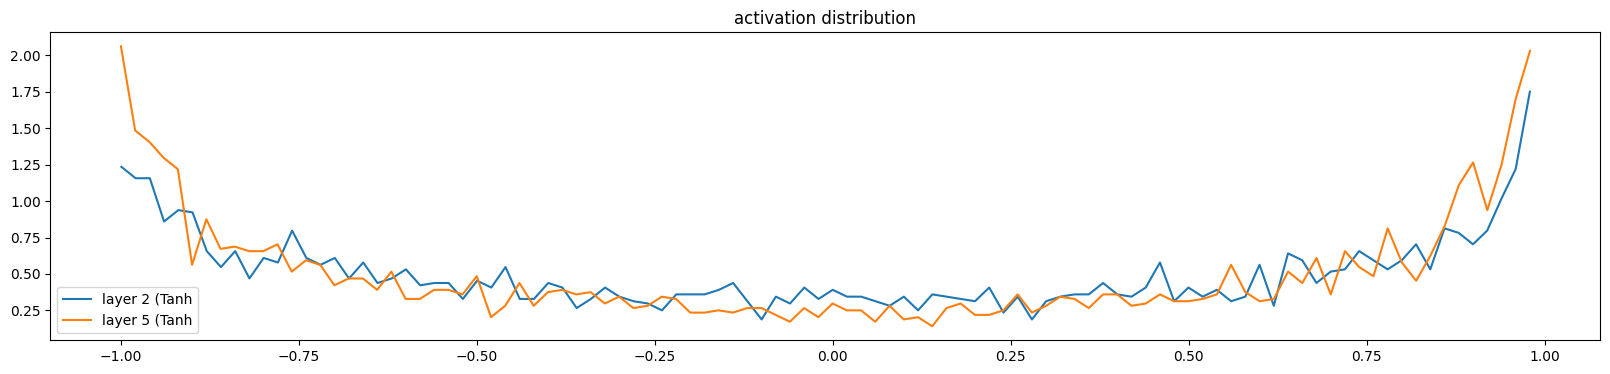

In [143]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh): # We're just seeing tanh because the values are finite: [-1, 1] but you could check other stuff. Anyways, pog!
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

## || ~1:47:00 added batchnorming, everything looks very good, 0.65 nice std, nice saturation and our standard deviations are ~equal throughout all our layers (it looks nice and homogenous). 

layer 2 (      Tanh): mean +0.000000, std 5.064265e-03
layer 5 (      Tanh): mean +0.000000, std 4.428972e-03


Text(0.5, 1.0, 'gradient distribution')

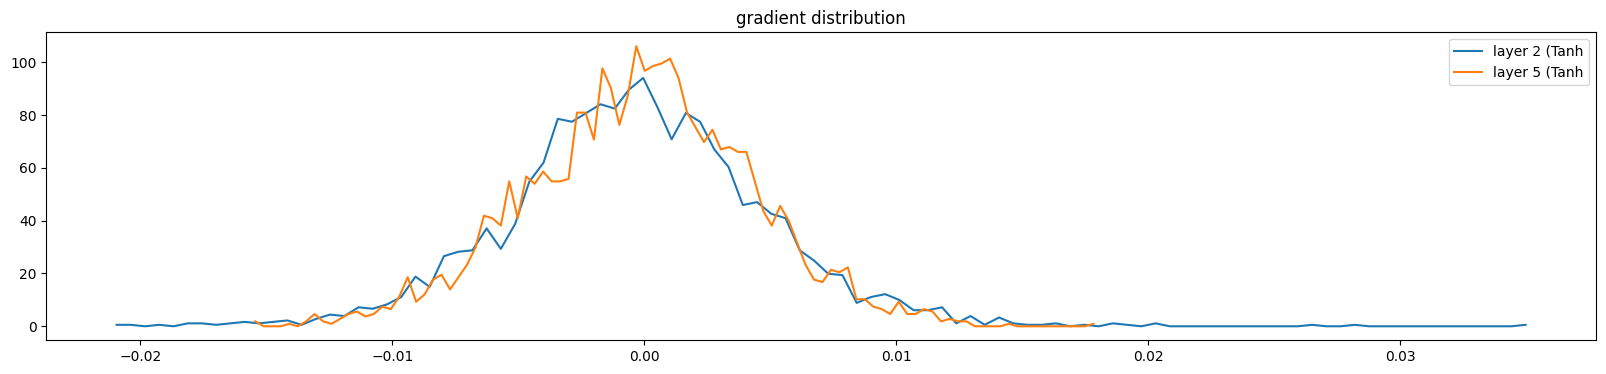

In [144]:
# visualize histograms. For gradients this time
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')
# || ~1:47:00 same as above, nice and clean

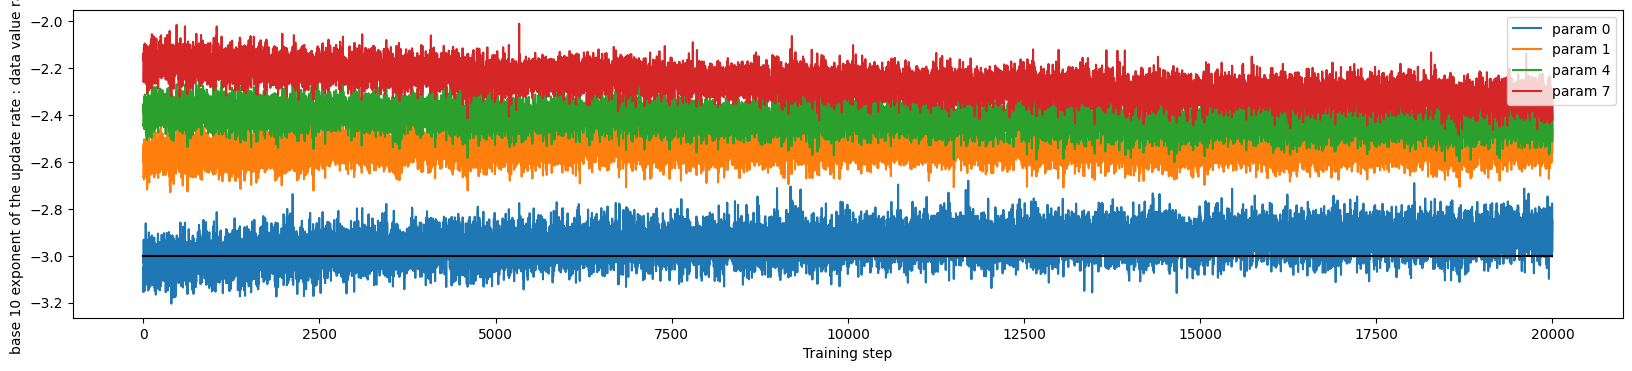

In [147]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: # weights only params (since they are 2D)
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot ||  I.e, whenever we're updating values for our params, we'd want the update to be ~1000x smaller than the actual value size.
plt.xlabel("Training step")
plt.ylabel("base 10 exponent of the update rate : data value ratio")
plt.legend(legends);

